In [1]:
#CHANGE PATH VARIABLE TO SOMETHING THAT WORKS ON YOUR COMPUTER AND DIRECTORY SYSTEM

import fasttext
import fasttext.util
import pandas as pd
import numpy as np
# !pip install openpyxl
df = pd.read_excel("annotations.xlsx")
dfy = pd.get_dummies(df.type)
dfx = df.text
ft = fasttext.load_model('fastText/cc.en.300.bin')
fasttext.util.reduce_model(ft,100)
ftfile = open("format.txt", "w")
for i in dfx:
    ftfile.write(i.lower() + "\n")
ftfile.close()
ftmodel = fasttext.train_unsupervised("format.txt")

In [2]:
print(df.type)
print(dfy)


0         right
1          left
2          left
3         right
4         right
          ...  
17770    center
17771      left
17772    center
17773      left
17774     right
Name: type, Length: 17775, dtype: object
       center  left  right
0           0     0      1
1           0     1      0
2           0     1      0
3           0     0      1
4           0     0      1
...       ...   ...    ...
17770       1     0      0
17771       0     1      0
17772       1     0      0
17773       0     1      0
17774       0     0      1

[17775 rows x 3 columns]


In [3]:
from keras.preprocessing.text import Tokenizer
vocab_size = len(ftmodel.words)
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(dfx)
dfx_nums = tokenizer.texts_to_sequences(dfx)
max_length = 100
padding_type = 'post'
truncation_type = 'post'
from keras.preprocessing.sequence import pad_sequences
dfx_nums_padded = pad_sequences(dfx_nums, maxlen = max_length, padding = padding_type, truncating = truncation_type)
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, max_length))
for word, i in tokenizer.word_index.items():
    embedding_vector = ftmodel.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [4]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, Dropout
embedding_layer = Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = max_length, weights = [embedding_matrix], trainable = False)
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split


def buildmodel():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(input_dim = max_length, filters = 100, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Bidirectional(LSTM(units = 15, return_sequences = False)))
    model.add(Dense(units = 10, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# estimator = KerasRegressor(build_fn = buildmodel, epochs = 5, batch_size = 32, verbose = 1)
# kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# results = cross_val_score(estimator, dfx_nums_padded, dfy, cv = kfold)

#actually build the model to generate the object
model = buildmodel()
X_train, X_test, y_train, y_test = train_test_split(dfx_nums_padded, dfy, test_size=0.2, random_state=42)
#model
# history = model.fit(X_train,y_train, epochs = 5)
history2 = model.fit(dfx_nums_padded, dfy, validation_split=0.33, epochs=50, verbose=1)


Epoch 1/50
373/373 [==============================] - 41s 89ms/step - loss: 0.5482 - accuracy: 0.5573 - val_loss: 0.4499 - val_accuracy: 0.7138
Epoch 2/50
373/373 [==============================] - 30s 79ms/step - loss: 0.2743 - accuracy: 0.8485 - val_loss: 0.1138 - val_accuracy: 0.9569
Epoch 3/50
373/373 [==============================] - 30s 81ms/step - loss: 0.0480 - accuracy: 0.9861 - val_loss: 0.0241 - val_accuracy: 0.9910
Epoch 4/50
373/373 [==============================] - 30s 81ms/step - loss: 0.0220 - accuracy: 0.9917 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 5/50
373/373 [==============================] - 31s 83ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/50
373/373 [==============================] - 31s 84ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.9220e-04 - val_accuracy: 1.0000
Epoch 7/50
373/373 [==============================] - 31s 84ms/step - loss: 6.3968e-04 - accuracy: 1.0000 - val_loss: 5.5011e-04 - v

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


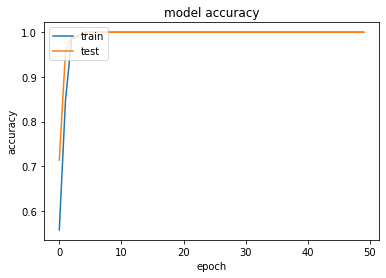

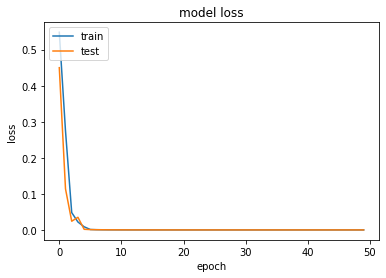

In [5]:

# list all data in history
print(history2.history.keys())

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()